#Neural Style Transfer
Artistic style transfer using pytorch.<br>
github: https://github.com/joey00072/Neural-Style-Transfer-in-Pytorch/



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision.utils import save_image

In [ ]:
#hyperparams

num_steps = 16000
learning_rate = 1e-2
alpha = 1
beta = 0.1
IMG_SIZE = 300 if torch.cuda.is_available() else 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("cuda" if torch.cuda.is_available() else "cpu")

cuda


In [ ]:
# utils

def load_img_as_tensor(img_name):
    img = cv2.imread(img_name)
    assert isinstance(img,np.ndarray) #To check if image exist

    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))

    img = torch.from_numpy(img/255) # np.array -> torch.tensor
    img = img.unsqueeze(0) # img.shape (IMG_SIZE,IMG_SIZE,3)->(1,IMG_SIZE,IMG_SIZE,3)

    #img - Batch,Hight,Width,Channels ->Batch,Channel,sHight,Width
    img = torch.einsum("bhwc->bchw",img)
    return img.float()


directory="out"
if not os.path.exists(directory):
    os.makedirs(directory)      # creting out folder

In [ ]:
# model

class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.features_layers = [0, 5, 10, 19, 28]

        self.model = models.vgg19(pretrained=True).eval()

        self.model = self.model.features[:29]

    def forward(self, x):
        features = []

        for idx, layer in enumerate(self.model):
            x = layer(x)

            if idx in self.features_layers:
                features.append(x)

        return features


In [ ]:
#Loss Function

def gram_matrix(x):
    batch, channels, hight, width = x.shape
    features = x.view(batch * channels, hight * width)
    G = torch.mm(features, features.t())
    return G


class StyleLoss(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.features = [out.detach() for out in features ]

        #precomputing gram matrix for features
        self.target_A = [gram_matrix(fe) for fe in self.features ]


    def forward(self, x):
        loss = 0
        for A, pred in zip(self.target_A, x):
            G = gram_matrix(pred)
            loss += F.mse_loss(A, G)
        return loss


class ContentLoss(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.features = [out.detach() for out in features]

    def forward(self, x):
        loss = 0
        for target, pred in zip(self.features, x):
            loss += F.mse_loss(target, pred)
        return loss

In [ ]:
def transfer(model,img,style,content):


    img = img.detach().clone().to(device).requires_grad_()

    optimizer = optim.Adam([img])

    style_feature = model(style)
    content_feature = model(content)

    content_loss = ContentLoss(content_feature)
    style_loss = StyleLoss(style_feature)

    for idx in tqdm(range(num_steps)):
        img_feature = model(img)

        c_loss = content_loss(img_feature)
        s_loss = style_loss(img_feature)

        loss = alpha * s_loss + beta * c_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx%200 ==0:
            save_image(img.clone().detach(),f'out/out_{(idx//200):04d}.jpg')

    return

--2023-01-09 04:38:25--  https://raw.githubusercontent.com/joey00072/Neural-Style-Transfer-in-Pytorch/master/images/content/kitten2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1026372 (1002K) [image/jpeg]
Saving to: ‘kitten2.jpg’

kitten2.jpg         100%[===================>]   1002K  --.-KB/s    in 0.008s  

2023-01-09 04:38:26 (129 MB/s) - ‘kitten2.jpg’ saved [1026372/1026372]



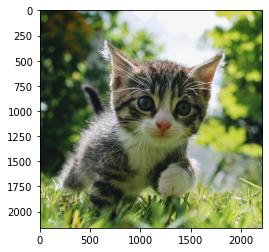

In [ ]:
#downloding images
content_name = "kitten2.jpg"

!wget https://raw.githubusercontent.com/joey00072/Neural-Style-Transfer-in-Pytorch/master/images/content/kitten2.jpg

img = Image.open(content_name)
plt.imshow(img)
plt.show()

--2023-01-09 04:44:02--  https://raw.githubusercontent.com/joey00072/Neural-Style-Transfer-in-Pytorch/master/images/style/style7.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123262 (120K) [image/jpeg]
Saving to: ‘style7.jpg.1’

style7.jpg.1        100%[===================>] 120.37K  --.-KB/s    in 0.003s  

2023-01-09 04:44:02 (44.3 MB/s) - ‘style7.jpg.1’ saved [123262/123262]



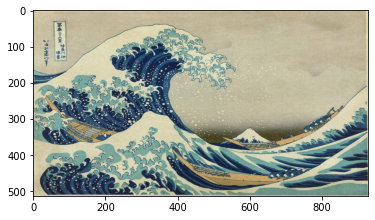

In [ ]:
style_name = "style7.jpg"

!wget https://raw.githubusercontent.com/joey00072/Neural-Style-Transfer-in-Pytorch/master/images/style/style7.jpg


img = Image.open(style_name)
plt.imshow(img)
plt.show()

In [ ]:
model = VGG().to(device).eval()

style_img = load_img_as_tensor(style_name).to(device)
content_img = load_img_as_tensor(content_name).to(device)


img = content_img.clone().to(device)

transfer(model,img,style_img,content_img)


100%|██████████| 1600/1600 [01:56<00:00, 13.79it/s]


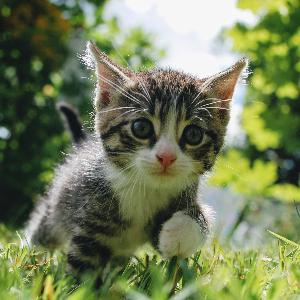

In [ ]:
Image.open(f'out/{sorted(os.listdir("out"))[0]}')

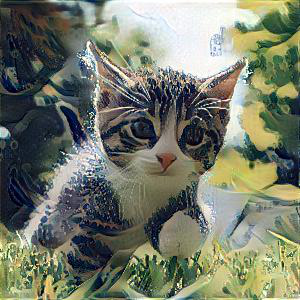

In [ ]:
Image.open(f'out/{sorted(os.listdir("out"))[-1]}')